In [25]:
import os
os.environ["FIFT_GL2D_DIR"] = "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"

import time
import pathlib
import numpy as np
import matplotlib.pyplot as plt

from fift import SIS, set_num_threads, FresnelHankelAxisymmetric, FresnelHankelAxisymmetricTrapezoidal
from fift.compare_utils import plot_overlays_ws

from glow import lenses as glow_lenses
from glow import time_domain_c, freq_domain_c

def check_precomputed_gl1d_files(n_gl, Umax, directory):
    """
    Check that the 1D Gauss–Legendre nodes/weights precomputed for (n_gl, Umax)
    exist in `directory`.

    We expect files:
        gl2d_n{n_gl}_U{int(Umax)}.x.npy
        gl2d_n{n_gl}_U{int(Umax)}.w.npy
    """
    if not directory:
        raise RuntimeError("FIFT_GL2D_DIR is not set.")

    base = f"gl2d_n{int(n_gl)}_U{int(Umax)}"
    required = [
        f"{base}.x.npy",
        f"{base}.w.npy",
    ]
    missing = []
    for fname in required:
        path = pathlib.Path(directory, fname)
        if not path.exists():
            missing.append(str(path))

    if missing:
        raise FileNotFoundError(
            "Missing precomputed GL1D files:\n  " + "\n  ".join(missing)
        )
    else:
        print(f"Found precomputed GL1D files for n_gl={n_gl}, Umax={Umax} in {directory}")


def compare_plot_GLoW_FIFT_Hankel(
    n=1024,
    Umax=50.0,
    tol=1e-12,
    lens=SIS(psi0=1.0),
    w_grid=np.logspace(-1.0, 1.0, 50),
    y_star=1.2,
    quadr='GL'
):

    gl_dir = os.environ.get("FIFT_GL2D_DIR")
    check_precomputed_gl1d_files(n, Umax, gl_dir)

    t0 = time.perf_counter()
    
    # ---------------- FIFT via Hankel (GL nodes + NUFHT) ----------------
    if quadr == 'GL':
        
        fresnel_ht = FresnelHankelAxisymmetric(
            lens,
            n_gl=n,
            Umax=Umax,
            gl_dir=gl_dir,
            tol=tol)
        
        quadr_title = 'GL+NUFHT'
        
    # ---------------- FIFT via Hankel (Uniform nodes + NUFHT) ----------------
    elif quadr == 'Trapezoidal':
        
        fresnel_ht = FresnelHankelAxisymmetricTrapezoidal(
            lens,
            n_r=n,
            Umax=Umax,
            tol=tol)
        
        quadr_title = 'Uniform+NUFHT'

    F_fift = fresnel_ht(w_grid, np.array([y_star]))[:, 0]
    t1 = time.perf_counter()
    fift_s = t1 - t0

    # ---------------- GLoW for comparison ----------------
    t2 = time.perf_counter()
    Psi = glow_lenses.Psi_SIS({'psi0': 1.0}, {})
    It  = time_domain_c.It_SingleIntegral_C(Psi, y=y_star)
    Fw  = freq_domain_c.Fw_FFT_C(It)
    F_glow = Fw(w_grid)
    t3 = time.perf_counter()
    glow_s = t3 - t2

    # ---------------- Plot and summary ----------------
    plot_overlays_ws(
        w_grid,
        F_fift,
        F_glow,
        n, Umax,
        title=f"SIS ({quadr_title}) @ y={y_star}",
        align_phase=True,
    )

    print(f"FIFT ({quadr_title}) time (single run): {fift_s:.4f} s")
    print(f"GLoW time (single run):                  {glow_s:.4f} s")
    print(f"Speedup (GLoW/FIFT-Hankel):              {glow_s / fift_s:.2f}×")

## Gauss-Legendre quadrature

Found precomputed GL1D files for n_gl=8000, Umax=70.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d
[FresnelHankelAxisymmetric GL_precomputed + NUFHT] avg 0.19 cores over 2.876s (0.2% of 112 logical cores; CPU sec=0.543)


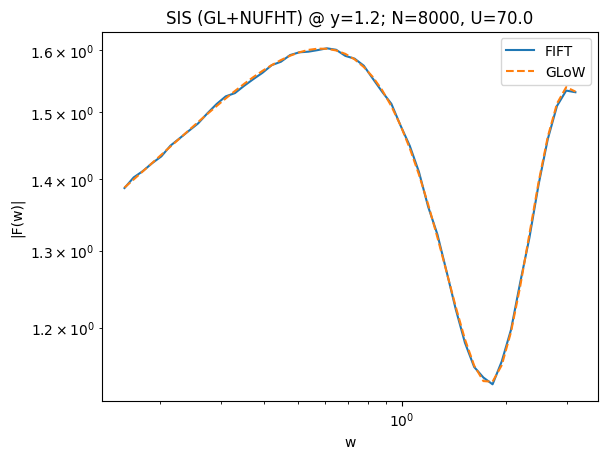

FIFT (Hankel GL+NUFHT) time (single run): 2.8806 s
GLoW time (single run):                  0.0107 s
Speedup (GLoW/FIFT-Hankel):              0.00×


In [16]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=70.0, tol=1e-13,
                              y_star=1.2, w_grid=np.logspace(-0.8, 0.5, 50),
                              quadr='GL')

Found precomputed GL1D files for n_gl=8000, Umax=180.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d
[FresnelHankelAxisymmetric GL_precomputed + NUFHT] avg 0.19 cores over 2.949s (0.2% of 112 logical cores; CPU sec=0.574)


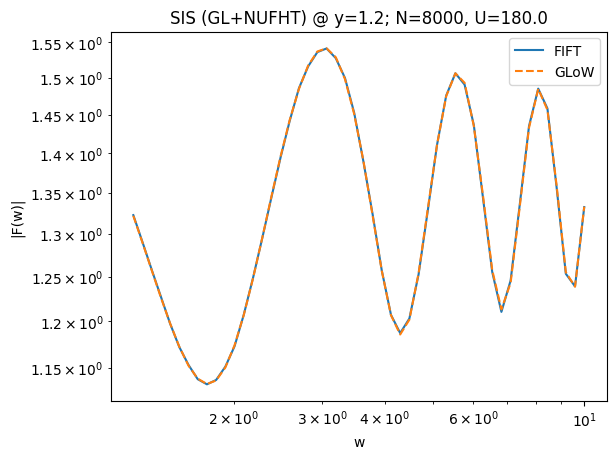

FIFT (Hankel GL+NUFHT) time (single run): 2.9529 s
GLoW time (single run):                  0.0098 s
Speedup (GLoW/FIFT-Hankel):              0.00×


In [17]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=180.0, tol=1e-13,
                              y_star=1.2, w_grid=np.logspace(0.1, 1.0, 50),
                              quadr='GL')

## Trapezoidal quadrature

Found precomputed GL1D files for n_gl=8000, Umax=70.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d
[FresnelHankelAxisymmetric] avg 0.28 cores over 3.446s (0.3% of 112 logical cores; CPU sec=0.968)


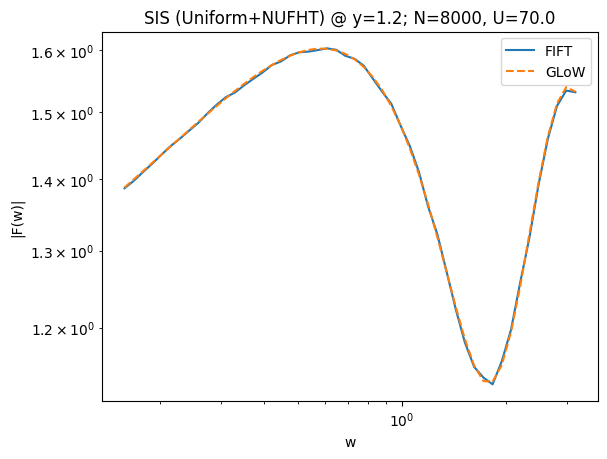

FIFT (Uniform+NUFHT) time (single run): 3.4471 s
GLoW time (single run):                  0.0189 s
Speedup (GLoW/FIFT-Hankel):              0.01×


In [26]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=70.0, tol=1e-13, y_star=1.2,
                              w_grid=np.logspace(-0.8, 0.5, 50),
                              quadr='Trapezoidal')

Found precomputed GL1D files for n_gl=8000, Umax=180.0 in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d
[FresnelHankelAxisymmetric] avg 0.35 cores over 3.892s (0.3% of 112 logical cores; CPU sec=1.370)


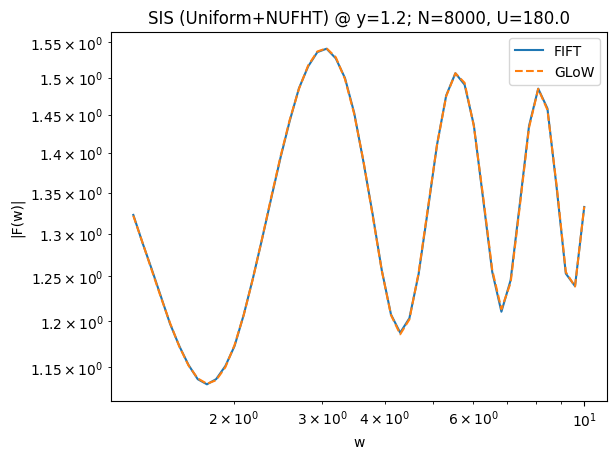

FIFT (Uniform+NUFHT) time (single run): 3.8936 s
GLoW time (single run):                  0.0217 s
Speedup (GLoW/FIFT-Hankel):              0.01×


In [27]:
compare_plot_GLoW_FIFT_Hankel(n=8000, Umax=180.0, tol=1e-13,
                              y_star=1.2, w_grid=np.logspace(0.1, 1.0, 50),
                              quadr='Trapezoidal')